# **CUHK-STAT3009** Notebook - Matrix Factorization: GD and SGD


In [1]:
# Load and pro-processed dataset
import numpy as np
import pandas as pd

## Upload Netflix dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['user_id', 'movie_id']].values

test_rating = dtest['rating'].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[['user_id', 'movie_id']].values

n_user = max( max(train_pair[:,0]), max(test_pair[:,0]) ) + 1
n_item = max( max(train_pair[:,1]), max(test_pair[:,1]) ) + 1

def rmse(test_rating, pred_rating):
    return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

## Implement GD for MF

- **ALS** structure with **GD** for solving each sub-problem
- One additional HP in GD: `step_size` or `learning_rate`
- Item-GD:
$$
\mathbf{q}^{(new)}_i = \mathbf{q}^{(old)}_i - 2 \alpha \big( - \frac{1}{|\Omega|} \sum_{u \in \mathcal{U}_i } \mathbf{p}_u (r_{ui} -\mathbf{p}_u^\intercal \mathbf{q}^{(old)}_i) + \lambda \mathbf{q}^{(old)}_i \big)
$$
- User-GD
$$
\mathbf{p}^{(new)}_u = \mathbf{p}^{(old)}_u - 2 \alpha \big( - \frac{1}{|\Omega|} \sum_{i \in \mathcal{I}_u } \mathbf{q}_i (r_{ui} - \mathbf{q}_i^\intercal \mathbf{p}^{(old)}_u)  + \lambda \mathbf{p}^{(old)}_u \big)
$$


In [2]:
class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, GDiterNum=10, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.GDiterNum = GDiterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                train_pair_tmp, train_rating_tmp = train_pair[index_item_tmp], train_rating[index_item_tmp]
                ## GD block
                for h in range(self.GDiterNum):
                  ## compute res on the current model
                  err_tmp = train_rating_tmp - self.predict(train_pair_tmp)
                  sum_pu = np.sum(self.P[train_pair_tmp[:,0]] * err_tmp[:,np.newaxis], 0) / n_obs
                  ## GD updates for Q
                  self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate * sum_pu - 2*learning_rate*lam*self.Q[item_id,:]
                
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                train_pair_tmp, train_rating_tmp = train_pair[index_user_tmp], train_rating[index_user_tmp]
                for h in range(self.GDiterNum):
                  err_tmp = train_rating_tmp - self.predict(train_pair_tmp)
                  sum_qi = np.sum(self.Q[train_pair_tmp[:,1]] * err_tmp[:,np.newaxis], 0) / n_obs
                  self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*sum_qi - 2*learning_rate*lam*self.P[user_id,:]

            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            rmse_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - obj_new + obj_old
            print("Reg-MF: GD - ite: %d; diff: %.3f; Obj: %.3f; RMSE: %.3f" %(i, diff, obj_new, rmse_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [5]:
# fitting
cue = MF(n_user, n_item, K=10, lam=.00001)
# For GD, to save training time, we can select a large lr first, then generally reduce...
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=10.)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 8.065; Obj: 16.717; RMSE: 4.034
Reg-MF: GD - ite: 1; diff: 2.332; Obj: 14.385; RMSE: 3.736
Reg-MF: GD - ite: 2; diff: 2.576; Obj: 11.809; RMSE: 3.374
Reg-MF: GD - ite: 3; diff: 3.443; Obj: 8.367; RMSE: 2.818
Reg-MF: GD - ite: 4; diff: 2.365; Obj: 6.001; RMSE: 2.361
Reg-MF: GD - ite: 5; diff: 1.318; Obj: 4.683; RMSE: 2.063
Reg-MF: GD - ite: 6; diff: 0.811; Obj: 3.872; RMSE: 1.856
Reg-MF: GD - ite: 7; diff: 0.545; Obj: 3.327; RMSE: 1.703
Reg-MF: GD - ite: 8; diff: 0.389; Obj: 2.938; RMSE: 1.584
Reg-MF: GD - ite: 9; diff: 0.291; Obj: 2.647; RMSE: 1.490
Reg-MF: GD - ite: 10; diff: 0.225; Obj: 2.423; RMSE: 1.412
Reg-MF: GD - ite: 11; diff: 0.178; Obj: 2.244; RMSE: 1.348
Reg-MF: GD - ite: 12; diff: 0.145; Obj: 2.100; RMSE: 1.293
Reg-MF: GD - ite: 13; diff: 0.119; Obj: 1.981; RMSE: 1.246
Reg-MF: GD - ite: 14; diff: 0.100; Obj: 1.881; RMSE: 1.205
Reg-MF: GD - ite: 15; diff: 0.085; Obj: 1.796; RMSE: 1.170
Reg-MF: GD - ite: 16; diff:

In [6]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=1.)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 0.000; Obj: 0.494; RMSE: 0.529


In [7]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.1)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 0.000; Obj: 0.494; RMSE: 0.529


In [8]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.01)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 0.000; Obj: 0.494; RMSE: 0.529


In [9]:
# pediction
pred_rating = cue.predict(test_pair)
pred_train_rating = cue.predict(train_pair)
print('train rmse: %.3f; test rmse: %.3f' %(rmse(train_rating, pred_train_rating), rmse(test_rating, pred_rating)))

train rmse: 0.529; test rmse: 1.320


## Solve **MF** by **SGD**

- SGD focus on just ONE sample:
	- Sample just one user-item pair $(u,i)$:
$$\text{argmin}_{\mathbf{p}_u, \mathbf{q}_i} \ (r_{ui} - \mathbf{p}^\intercal_u \mathbf{q}_i )^2 + \lambda \big( \| \mathbf{p}_u \|_2^2 + \mathbf{q}_i \|_2^2 \big)
$$

- Upadte the corresponding **gradient** for $\mathbf{p}_u$ and $\mathbf{q}_i$, and updates $\mathbf{p}_u$ and $\mathbf{q}_i$ as follows:
$$
\mathbf{q}^{(l+1)}_i = \mathbf{q}^{(l)}_i + 2 \alpha \big( (r_{ui} - (\mathbf{p}^{(l)}_u)^\intercal \mathbf{q}^{(l)}_i) \mathbf{p}^{(l)}_u - \lambda \mathbf{q}^{(l)}_i \big),
$$
$$
\mathbf{p}^{(l+1)}_u = \mathbf{p}^{(l)}_u + 2 \alpha \big( (r_{ui} - (\mathbf{q}^{(l+1)}_i)^\intercal \mathbf{p}^{(l)}_u) \mathbf{q}^{(l+1)}_i - \lambda \mathbf{p}^{(l)}_u \big)
$$

In [16]:
class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## SGD updates
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for j in range(n_obs):
                user_id, item_id, rating_tmp = train_pair[j,0], train_pair[j,1], train_rating[j]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate*err_tmp*self.P[user_id,:] - 2*learning_rate*lam*self.Q[item_id,:]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*self.Q[item_id,:] - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            rmse_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - obj_new + obj_old
            print("Reg-MF: GD - ite: %d; diff: %.3f; Obj: %.3f; RMSE: %.3f" %(i, diff, obj_new, rmse_new))

            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )


In [18]:
# fitting
cue = MF(n_user, n_item, K=10, lam=.00001)
# For GD, to save training time, we can select a large lr first, then generally reduce...
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.01)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 10.757; Obj: 13.740; RMSE: 3.637
Reg-MF: GD - ite: 1; diff: 5.064; Obj: 8.676; RMSE: 2.854
Reg-MF: GD - ite: 2; diff: 1.296; Obj: 7.381; RMSE: 2.610
Reg-MF: GD - ite: 3; diff: -0.465; Obj: 7.845; RMSE: 2.689


In [19]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.001)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 2.335; Obj: 5.511; RMSE: 2.212
Reg-MF: GD - ite: 1; diff: 0.274; Obj: 5.237; RMSE: 2.148
Reg-MF: GD - ite: 2; diff: 0.117; Obj: 5.119; RMSE: 2.119
Reg-MF: GD - ite: 3; diff: 0.065; Obj: 5.054; RMSE: 2.103
Reg-MF: GD - ite: 4; diff: 0.042; Obj: 5.012; RMSE: 2.091
Reg-MF: GD - ite: 5; diff: 0.030; Obj: 4.982; RMSE: 2.083
Reg-MF: GD - ite: 6; diff: 0.022; Obj: 4.960; RMSE: 2.076
Reg-MF: GD - ite: 7; diff: 0.017; Obj: 4.942; RMSE: 2.071
Reg-MF: GD - ite: 8; diff: 0.014; Obj: 4.929; RMSE: 2.066
Reg-MF: GD - ite: 9; diff: 0.011; Obj: 4.917; RMSE: 2.062
Reg-MF: GD - ite: 10; diff: 0.009; Obj: 4.908; RMSE: 2.059
Reg-MF: GD - ite: 11; diff: 0.008; Obj: 4.901; RMSE: 2.056
Reg-MF: GD - ite: 12; diff: 0.006; Obj: 4.894; RMSE: 2.053
Reg-MF: GD - ite: 13; diff: 0.005; Obj: 4.889; RMSE: 2.051
Reg-MF: GD - ite: 14; diff: 0.004; Obj: 4.885; RMSE: 2.048
Reg-MF: GD - ite: 15; diff: 0.003; Obj: 4.881; RMSE: 2.046
Reg-MF: GD - ite: 16; diff: 0.

In [20]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.0001)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 0.076; Obj: 4.797; RMSE: 2.016
Reg-MF: GD - ite: 1; diff: 0.016; Obj: 4.781; RMSE: 2.012
Reg-MF: GD - ite: 2; diff: 0.006; Obj: 4.775; RMSE: 2.010
Reg-MF: GD - ite: 3; diff: 0.003; Obj: 4.772; RMSE: 2.009
Reg-MF: GD - ite: 4; diff: 0.002; Obj: 4.769; RMSE: 2.009
Reg-MF: GD - ite: 5; diff: 0.002; Obj: 4.768; RMSE: 2.008
Reg-MF: GD - ite: 6; diff: 0.001; Obj: 4.766; RMSE: 2.008
Reg-MF: GD - ite: 7; diff: 0.001; Obj: 4.765; RMSE: 2.007
Reg-MF: GD - ite: 8; diff: 0.001; Obj: 4.765; RMSE: 2.007
Reg-MF: GD - ite: 9; diff: 0.001; Obj: 4.764; RMSE: 2.007
Reg-MF: GD - ite: 10; diff: 0.001; Obj: 4.763; RMSE: 2.006
Reg-MF: GD - ite: 11; diff: 0.001; Obj: 4.762; RMSE: 2.006
Reg-MF: GD - ite: 12; diff: 0.001; Obj: 4.762; RMSE: 2.006
Reg-MF: GD - ite: 13; diff: 0.000; Obj: 4.761; RMSE: 2.005
Reg-MF: GD - ite: 14; diff: 0.000; Obj: 4.761; RMSE: 2.005
Reg-MF: GD - ite: 15; diff: 0.000; Obj: 4.761; RMSE: 2.005
Reg-MF: GD - ite: 16; diff: 0.

In [21]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.00001)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 0.000; Obj: 4.756; RMSE: 2.001
Reg-MF: GD - ite: 1; diff: 0.000; Obj: 4.756; RMSE: 2.001
Reg-MF: GD - ite: 2; diff: 0.000; Obj: 4.756; RMSE: 2.001
Reg-MF: GD - ite: 3; diff: 0.000; Obj: 4.756; RMSE: 2.001
Reg-MF: GD - ite: 4; diff: 0.000; Obj: 4.755; RMSE: 2.001
Reg-MF: GD - ite: 5; diff: 0.000; Obj: 4.755; RMSE: 2.001
Reg-MF: GD - ite: 6; diff: 0.000; Obj: 4.755; RMSE: 2.001


## **Cross-validation** for **MF**

- We use **ALS/BCD** to solve every **MF** (since it is most efficient)

- Use 5-fold CV to determine the best HPs

- The Grid in the code is just for demonstration, the performance can be further improved by carefully tune the Grid

In [22]:
## Recall the MF via ALS

class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        
        if self.verbose:
            print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        
        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                ## compute `sum_pu` and `sum_matrix`
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is worning in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                ## compute `sum_qi` and `sum_matrix`
                sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is worning in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_qi = sum_qi + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            diff = abs(obj_new - obj_old) / obj_old
            if self.verbose:
                print("Reg-MF: ite: %d; diff: %.3f Obj: %.3f" %(i, diff, obj_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )
      
    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

In [23]:
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class MF_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = MF(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

In [28]:
## class for baseline methods
class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

In [29]:
## Baseline models
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
train_rating_res = train_rating - user_ave.predict(train_pair)
pred = user_ave.predict(test_pair)

## item_mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_res)
train_rating_res = train_rating_res - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

print('user-item mean rmse: %.3f' %rmse(test_rating, pred))

user-item mean rmse: 0.976


3-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.672, valid_rmse: 1.063
3-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.667, valid_rmse: 1.037
3-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.671, valid_rmse: 1.051
3-Fold CV for K: 3; lam: 0.00003: train_rmse: 0.686, valid_rmse: 0.989
3-Fold CV for K: 3; lam: 0.00003: train_rmse: 0.693, valid_rmse: 0.980
3-Fold CV for K: 3; lam: 0.00003: train_rmse: 0.690, valid_rmse: 0.992
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.735, valid_rmse: 0.926
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.735, valid_rmse: 0.930
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.738, valid_rmse: 0.914
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.824, valid_rmse: 0.871
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.822, valid_rmse: 0.879
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.825, valid_rmse: 0.874
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.883, valid_rmse: 0.877
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.875, valid_rmse: 0.892
3-Fold

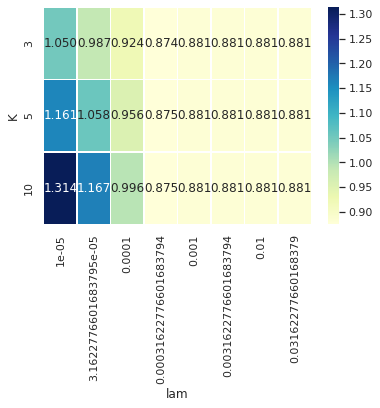

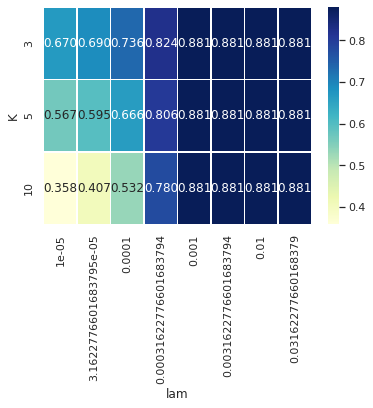

In [30]:
Ks, lams = [3, 5, 10], 10**np.arange(-5, -1, .5)

MF_cv = MF_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
MF_cv.grid_search(train_pair, train_rating_res)
MF_cv.plot_grid('valid')
MF_cv.plot_grid('train')

In [31]:
MF_cv.cv_result

,K,lam,train_rmse,valid_rmse
0,3,0.000010,0.670104,1.049989
1,3,0.000032,0.689655,0.986770
2,3,0.000100,0.735820,0.923531
3,3,0.000316,0.823671,0.874418
4,3,0.001000,0.880660,0.880635
5,3,0.003162,0.880669,0.880667
6,3,0.010000,0.880665,0.880650
7,3,0.031623,0.880667,0.880658
8,5,0.000010,0.566903,1.161174
9,5,0.000032,0.595106,1.057716


In [32]:
MF_cv.best_model

K             3.000000
lam           0.000316
train_rmse    0.823671
valid_rmse    0.874418
Name: 3, dtype: float64

In [35]:
## refit the best model by the best tuned Hps
best_MF = MF(n_user, n_item, K=int(MF_cv.best_model['K']), lam=MF_cv.best_model['lam'], verbose=1)
best_MF.fit(train_pair, train_rating_res)

Fitting Reg-MF: K: 3, lam: 0.00032
Reg-MF: ite: 0; diff: 0.911 Obj: 0.785
Reg-MF: ite: 1; diff: 0.013 Obj: 0.774
Reg-MF: ite: 2; diff: 0.004 Obj: 0.771
Reg-MF: ite: 3; diff: 0.005 Obj: 0.768
Reg-MF: ite: 4; diff: 0.003 Obj: 0.766
Reg-MF: ite: 5; diff: 0.001 Obj: 0.765
Reg-MF: ite: 6; diff: 0.000 Obj: 0.765
Reg-MF: ite: 7; diff: 0.000 Obj: 0.764
Reg-MF: ite: 8; diff: 0.000 Obj: 0.764
Reg-MF: ite: 9; diff: 0.000 Obj: 0.764


In [36]:
pred = pred + best_MF.predict(test_pair)
print('user-item mean rmse: %.3f' %rmse(test_rating, pred))

user-item mean rmse: 0.966
